In [43]:
import torch
import torch.nn.functional as F
import torchaudio
import torchaudio.transforms as T
import numpy as np
from torchmetrics.audio import SignalNoiseRatio
from torchmetrics import MeanSquaredError
from pesq import pesq
from pystoi import stoi

def compute_metrics(denoised, clean, sr):
    # Ensure contiguous tensors
    denoised = denoised.contiguous()
    clean = clean.contiguous()

    device = denoised.device

    # Resample both to 16kHz for PESQ/STOI consistency
    target_sr = 16000
    if sr != target_sr:
        resample = T.Resample(orig_freq=sr, new_freq=target_sr).to(device)
        denoised = resample(denoised)
        clean = resample(clean)
        sr = target_sr

    # Compute SNR and MSE
    snr = SignalNoiseRatio().to(device)(denoised, clean).item()
    mse = MeanSquaredError().to(device)(denoised, clean).item()

    # Compute LSD
    clean_log = torch.log10(torch.abs(clean) + 1e-6)
    denoised_log = torch.log10(torch.abs(denoised) + 1e-6)
    lsd = torch.mean(torch.sqrt(torch.mean((clean_log - denoised_log) ** 2, dim=-1))).item()

    # Convert to NumPy
    clean_np = clean.squeeze().cpu().numpy().flatten()
    denoised_np = denoised.squeeze().cpu().numpy().flatten()

    clean_np = np.clip(clean_np, -1.0, 1.0)
    denoised_np = np.clip(denoised_np, -1.0, 1.0)

    if (
        clean_np.shape[0] < 160 or denoised_np.shape[0] < 160 or
        np.any(np.isnan(clean_np)) or np.any(np.isnan(denoised_np)) or
        np.any(np.isinf(clean_np)) or np.any(np.isinf(denoised_np)) or
        np.allclose(clean_np, 0, atol=1e-5) or np.allclose(denoised_np, 0, atol=1e-5)
    ):
        pesq_score = 0.0
        stoi_score = 0.0
    else:
        pesq_score = pesq(sr, clean_np, denoised_np, 'wb')
        stoi_score = stoi(clean_np, denoised_np, sr, extended=False)

    return snr, mse, lsd, pesq_score, stoi_score


In [44]:
import torchaudio
import torch
import os
import pandas as pd

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

methods = [ "ConvTasNet","Demucs", "VoiceFix", "DeepFilterNet"]
files = ["p232_334", "sp07"]
base_dir = "/opt/users/gpel0001/nnc-fyp/.Project/Output/wav/vsPre"

results = {}

for method in methods:
    for fname in files:
        den_path = os.path.join(base_dir, f"{method}_{fname}.wav")
        clean_path = os.path.join(base_dir, f"clean_{fname}.wav")

        if not os.path.exists(den_path) or not os.path.exists(clean_path):
            print(f"[!] Missing file for {method} {fname}")
            continue

        den_wave, den_sr = torchaudio.load(den_path)
        clean_wave, clean_sr = torchaudio.load(clean_path)

        if den_wave.shape[0] > 1:
            den_wave = den_wave.mean(dim=0, keepdim=True)
        if clean_wave.shape[0] > 1:
            clean_wave = clean_wave.mean(dim=0, keepdim=True)

        # Align duration
        min_len = min(den_wave.shape[-1], clean_wave.shape[-1])
        den_wave = den_wave[..., :min_len]
        clean_wave = clean_wave[..., :min_len]

        den_wave = den_wave.to(device)
        clean_wave = clean_wave.to(device)

        # Use sample rate from clean file
        snr, mse, lsd, pesq_score, stoi_score = compute_metrics(den_wave, clean_wave, clean_sr)

        key = f"{method}_{fname}"
        results[key] = {
            "↑SNR": snr,
            "↓MSE": mse,
            "↓LSD": lsd,
            "↑PESQ": pesq_score,
            "↑STOI": stoi_score
        }

# Tabulate results
df_results = pd.DataFrame(results).T
df_results = df_results[["↑SNR", "↓MSE","↑PESQ", "↑STOI", "↓LSD"]].round(4)
display(df_results)


,↑SNR,↓MSE,↑PESQ,↑STOI,↓LSD
ConvTasNet_p232_334,12.4030,0.0002,2.8491,0.9928,0.4709
ConvTasNet_sp07,-5.8487,0.0059,1.0361,0.2303,1.6140
Demucs_p232_334,-2.9463,0.0093,1.2093,0.0995,0.9278
Demucs_sp07,-4.9523,0.0048,1.0424,0.2431,1.3780
VoiceFix_p232_334,-2.2635,0.0079,1.1860,0.0094,0.9664
VoiceFix_sp07,-7.3720,0.0084,1.0380,0.1934,1.5654
DeepFilterNet_p232_334,21.6161,0.0000,3.5558,0.9917,0.4597
DeepFilterNet_sp07,4.2464,0.0006,1.3363,0.8481,1.0116


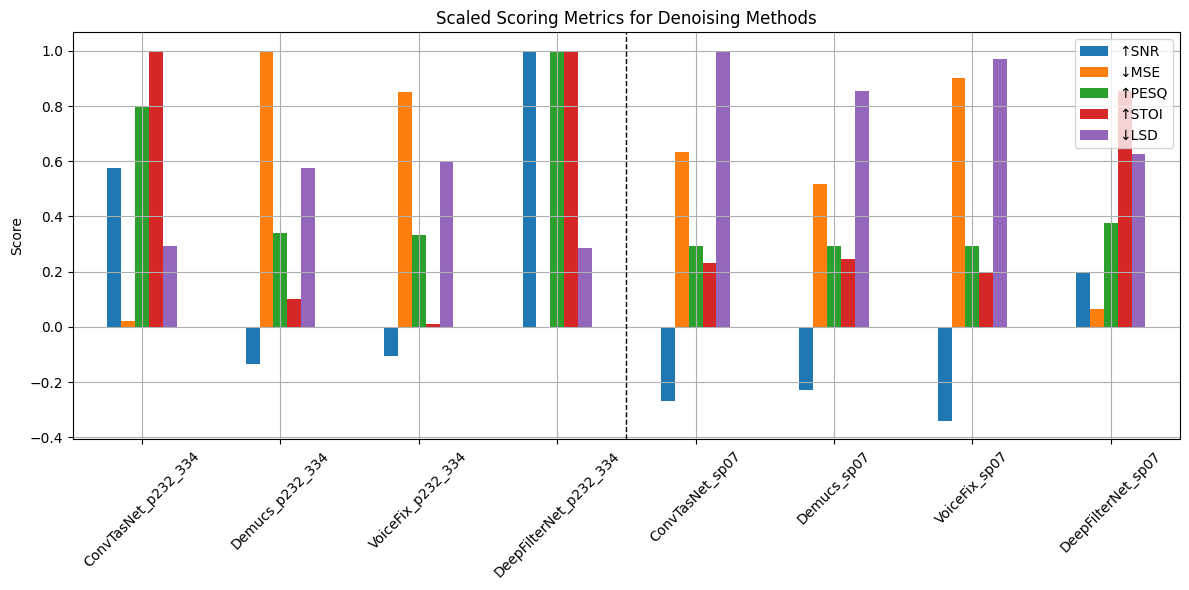

In [45]:
import matplotlib.pyplot as plt

# Scale all results to [0, 1] for better visualization
df_results["↑SNR"] = df_results["↑SNR"] / df_results["↑SNR"].max()
df_results["↑PESQ"] = df_results["↑PESQ"] / df_results["↑PESQ"].max()
df_results["↑STOI"] = df_results["↑STOI"] / df_results["↑STOI"].max()
df_results["↓MSE"] = df_results["↓MSE"] / df_results["↓MSE"].max()
df_results["↓LSD"] = df_results["↓LSD"] / df_results["↓LSD"].max()

# Place p232_334 and sp07 near each other
df_results = df_results.reindex(
    ["ConvTasNet_p232_334", "Demucs_p232_334", "VoiceFix_p232_334", "DeepFilterNet_p232_334",
     "ConvTasNet_sp07", "Demucs_sp07", "VoiceFix_sp07", "DeepFilterNet_sp07"]
)


# Plot the table directly
df_results.plot(
    kind="bar", 
    figsize=(12, 6), 
    title="Scaled Scoring Metrics for Denoising Methods",
)
# Add deviders between p232_334 and sp07
plt.axvline(x=3.5, color='k', linestyle='--', linewidth=1)

plt.ylabel("Score")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()
